--- Data Loading ---
Loading data from: BTCUSD.csv
Selected last 15000 rows.

--- Feature Engineering ---
Feature engineering complete. Took 0.02 seconds.
Columns after features: 51

--- Target Definition ---
Defining target as 24h future return >= 2.5%...

--- Data Preparation ---
NaN Handling: Dropped 197 rows.
Replacing 8 infinites...
Dropped 8 more rows.
Final feature matrix shape: (14795, 42)
Target vector shape: (14795,)
Using 42 features.

--- Starting SLIDING Window Backtest with Per-Step HParam Tuning ---
!!! WARNING: This will be significantly slower due to GridSearchCV in each step !!!
Train Window: 1344 rows, Step: 24 rows, Test Window: 268 rows, Tuning Grid Size: 48

--- Step 1 (Predicting for window starting 2023-09-21 02:00:00) ---
  Training window: [0:1343]; Testing window: [1344:1611]
  Running GridSearchCV (cv=3, scoring='f1')...
  GridSearchCV finished in 5.10s.
  Best Params: {'colsample_bytree': 0.72, 'max_depth': 7, 'n_estimators': 147, 'reg_alpha': 0.26, 'subsam

Traceback (most recent call last):
  File "C:\Users\mason\AppData\Local\Temp\ipykernel_43288\2957371312.py", line 257, in <module>
    grid_search.fit(X_train_roll, y_train_roll) # Fit GridSearch
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mason\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mason\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py", line 898, in fit
    self._run_search(evaluate_candidates)
  File "C:\Users\mason\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py", line 1422, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "C:\Users\mason\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_search.py", line 845, in evaluate_candidates
    out = parallel(
          ^^^^^^^^^
  File "C:\

  GridSearchCV finished in 6.25s.
  Best Params: {'colsample_bytree': 0.72, 'max_depth': 9, 'n_estimators': 147, 'reg_alpha': 0.14, 'subsample': 0.92}, Best CV F1: 0.8084
  Step 246 finished in 6.37s total.

--- Step 247 (Predicting for window starting 2024-05-25 02:00:00) ---
  Training window: [5928:7271]; Testing window: [7272:7539]
  Running GridSearchCV (cv=3, scoring='f1')...
  GridSearchCV finished in 3.38s.
  Best Params: {'colsample_bytree': 0.68, 'max_depth': 6, 'n_estimators': 112, 'reg_alpha': 0.14, 'subsample': 0.92}, Best CV F1: 0.7865
  Step 247 finished in 3.49s total.

--- Step 248 (Predicting for window starting 2024-05-26 02:00:00) ---
  Training window: [5952:7295]; Testing window: [7296:7563]
  Running GridSearchCV (cv=3, scoring='f1')...
  GridSearchCV finished in 3.49s.
  Best Params: {'colsample_bytree': 0.68, 'max_depth': 7, 'n_estimators': 147, 'reg_alpha': 0.14, 'subsample': 0.92}, Best CV F1: 0.7719
  Step 248 finished in 3.64s total.

--- Step 249 (Predicti

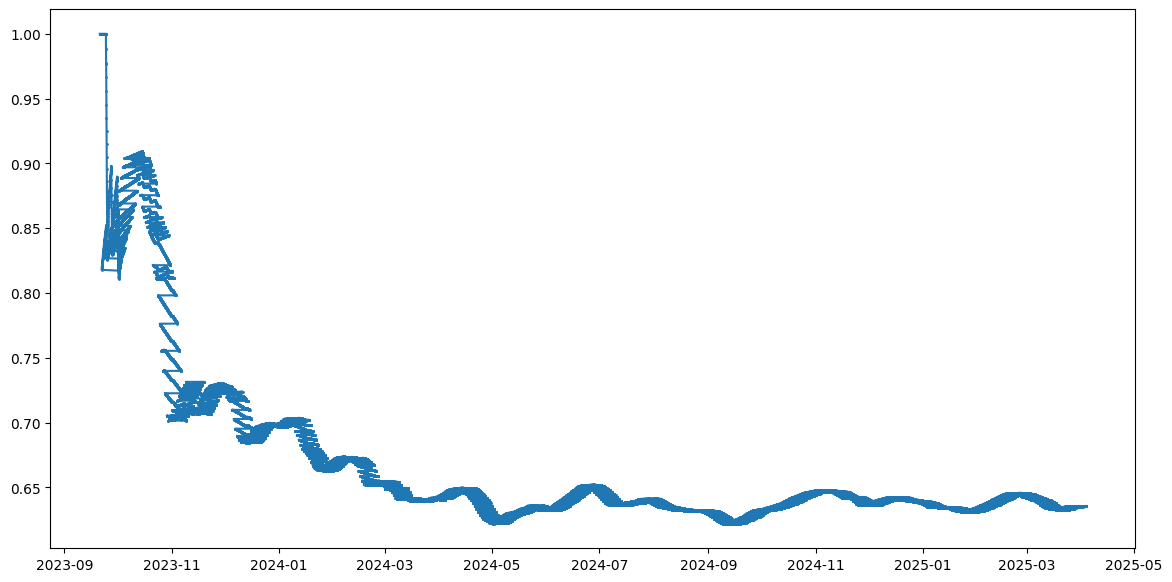

In [1]:
# B3_Configurable.py
# Simple Predictor with Sliding Window, Per-Step HParam Tuning, and PTT
# Configurable parameters at the top. Uses an evaluation window per step.

import pandas as pd
import numpy as np
import time
import os
import warnings
import traceback
from datetime import datetime
import xgboost as xgb
import matplotlib.pyplot as plt

# Modeling Imports
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, ParameterGrid
from sklearn.exceptions import UndefinedMetricWarning

# --- Suppress Warnings ---
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore')

# ==============================================================================
# --- Configuration ---
# ==============================================================================

# --- Data ---
CSV_FILE_PATH = 'BTCUSD.csv'
N_ROWS_INPUT = 15000          # Number of most recent rows to load from CSV

# --- Target Definition ---
PREDICTION_WINDOW_HOURS = 24  # How many hours ahead to predict
TARGET_THRESHOLD_PCT = 2.5   # Target threshold for positive class (>= this value is 1)

# --- Backtesting Windowing ---
TRAIN_WINDOW_HOURS = 24 * 7 * 8  # Size of the sliding training window (e.g., 8 weeks)
STEP_HOURS = 24                  # How often to retrain/predict (e.g., daily)
# Test window size as a fraction of the training window
TEST_WINDOW_FRACTION = 0.2       # e.g., 0.2 means test window is 20% of train window

# --- Model & Tuning ---
# Fixed XGBoost parameters (not tuned in grid search)
XGB_FIXED_PARAMS = {
    'learning_rate': 0.086,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False, # Deprecated, use False
    'random_state': 42,
    'reg_lambda': 4.0,         # L2 Regularization (Example value)
    'n_jobs': -1               # Use all available CPU cores
}

# Parameter grid for GridSearchCV (Keep combinations reasonable)
XGB_PARAM_GRID_TUNE = {
    'max_depth': [6, 7, 9],          # 3 options
    'n_estimators': [112, 147],       # 2 options
    'subsample': [0.83, 0.92],         # 2 options
    'colsample_bytree': [0.68, 0.72],  # 2 options
    'reg_alpha': [0.14, 0.26]         # L1 Regularization (2 options)
} # Total combinations: 3 * 2 * 2 * 2 * 2 = 48

# Probability Threshold Tuning Range
PROBABILITY_THRESHOLD_RANGE = (0.10, 0.90) # Start to end (end exclusive)
PROBABILITY_THRESHOLD_STEP = 0.05

# ==============================================================================
# --- Derived Variables (Do not change these directly) ---
# ==============================================================================
TRAIN_WINDOW_ROWS = TRAIN_WINDOW_HOURS
STEP_ROWS = STEP_HOURS
PREDICTION_WINDOW_ROWS = PREDICTION_WINDOW_HOURS
TEST_WINDOW_ROWS = max(1, int(TEST_WINDOW_FRACTION * TRAIN_WINDOW_ROWS)) # Ensure at least 1 row
THRESHOLD_SEARCH_RANGE = np.arange(
    PROBABILITY_THRESHOLD_RANGE[0],
    PROBABILITY_THRESHOLD_RANGE[1],
    PROBABILITY_THRESHOLD_STEP
)
try:
    grid_combinations = len(list(ParameterGrid(XGB_PARAM_GRID_TUNE))) # Calculate grid size
except TypeError: # Handle case where grid might be None or empty
    grid_combinations = 1

# ==============================================================================
# --- Script Start ---
# ==============================================================================

# --- 1. Load Data and Select Last Rows ---
print("--- Data Loading ---")
print(f"Loading data from: {CSV_FILE_PATH}")
try:
    df_full = pd.read_csv(CSV_FILE_PATH)
    df_full = df_full.sort_values(by='unix', ascending=True).reset_index(drop=True)
    if 'date' in df_full.columns:
        try: df_full['date'] = pd.to_datetime(df_full['date'])
        except Exception as e_date: print(f"Warning: Date parse error: {e_date}")

    if len(df_full) < N_ROWS_INPUT:
        print(f"Warning: Full dataset ({len(df_full)} rows) < {N_ROWS_INPUT}. Using all data.")
        df = df_full.copy()
    else:
        df = df_full.iloc[-N_ROWS_INPUT:].reset_index(drop=True)
        print(f"Selected last {len(df)} rows.")
except FileNotFoundError: print(f"Error: {CSV_FILE_PATH} not found."); exit()
except Exception as e: print(f"Error loading data: {e}"); exit()

# --- 2. Feature Engineering ---
print("\n--- Feature Engineering ---")
start_fe = time.time()
base_cols_numeric = ['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD']
for col in base_cols_numeric:
    if col in df.columns: df[col] = pd.to_numeric(df[col], errors='coerce')
    else: print(f"Warning: Missing base column '{col}'"); df[col] = 0
if df[['open', 'high', 'low', 'close']].isnull().any().any():
    print("Warning: OHLC NaNs found. Dropping rows."); df = df.dropna(subset=['open', 'high', 'low', 'close'])
if df.empty: exit("Error: Empty DF after initial OHLC NaN drop.")
# --- Feature Functions ---
def garman_klass_volatility(o, h, l, c, w):
    with np.errstate(divide='ignore', invalid='ignore'): log_hl=np.log(h/l.replace(0,np.nan)); log_co=np.log(c/o.replace(0,np.nan))
    gk = 0.5*(log_hl**2) - (2*np.log(2)-1)*(log_co**2); gk = gk.fillna(0)
    rm = gk.rolling(w, min_periods=max(1,w//2)).mean(); rm = rm.clip(lower=0); return np.sqrt(rm)
def parkinson_volatility(h, l, w):
    with np.errstate(divide='ignore', invalid='ignore'): log_hl_sq = np.log(h/l.replace(0,np.nan))**2
    log_hl_sq = log_hl_sq.fillna(0); rs = log_hl_sq.rolling(w,min_periods=max(1,w//2)).sum()
    f = 1/(4*np.log(2)*w) if w>0 else 0; return np.sqrt(f*rs)
# --- Feature Calculations (Example subset, add all relevant ones from B2_V2) ---
df['price_change_1h_temp'] = df['close'].pct_change()
with np.errstate(divide='ignore', invalid='ignore'):
    df['price_range_pct'] = (df['high'] - df['low']) / df['close'].replace(0, np.nan) * 100
    df['oc_change_pct'] = (df['close'] - df['open']) / df['open'].replace(0, np.nan) * 100
df['garman_klass_12h'] = garman_klass_volatility(df['open'],df['high'],df['low'],df['close'],12)
df['parkinson_3h'] = parkinson_volatility(df['high'],df['low'],3)
min_periods_rolling = 2
df['ma_3h'] = df['close'].rolling(3, min_periods=min_periods_rolling).mean()
df['rolling_std_3h'] = df['close'].rolling(3, min_periods=min_periods_rolling).std()
lag_periods_price = [3, 6, 12, 24, 48, 72, 168]; lag_periods_volume = [3, 6, 12, 24]
for lag in lag_periods_price: df[f'lag_{lag}h_price_return'] = df['price_change_1h_temp'].shift(lag) * 100
df['volume_return_1h'] = df['Volume BTC'].pct_change() * 100
for lag in lag_periods_volume: df[f'lag_{lag}h_volume_return'] = df['volume_return_1h'].shift(lag)
ma_periods = [6, 12, 24, 48, 72, 168]; std_periods = [6, 12, 24, 48, 72, 168]
for p in ma_periods: df[f'ma_{p}h'] = df['close'].rolling(p, min_periods=max(min_periods_rolling, p//2)).mean()
for p in std_periods: df[f'rolling_std_{p}h'] = df['price_change_1h_temp'].rolling(p, min_periods=max(min_periods_rolling, p//2)).std() * 100
df['prev_close']=df['close'].shift(1); df['hml']=df['high']-df['low']; df['hmpc']=np.abs(df['high']-df['prev_close']); df['lmpc']=np.abs(df['low']-df['prev_close'])
df['tr']=df[['hml','hmpc','lmpc']].max(axis=1)
atr_periods = [14, 24, 48]
for p in atr_periods: df[f'atr_{p}h'] = df['tr'].rolling(p, min_periods=max(1,p//2)).mean()
df = df.drop(columns=['prev_close', 'hml', 'hmpc', 'lmpc', 'tr'])
epsilon = 1e-9
for p in [24, 48, 168]:
    mc=f'ma_{p}h'; df[f'close_div_ma_{p}h'] = df['close']/(df[mc]+epsilon) if mc in df else np.nan
if 'ma_12h' in df and 'ma_48h' in df: df['ma12_div_ma48'] = df['ma_12h']/(df['ma_48h']+epsilon)
else: df['ma12_div_ma48']=np.nan
if 'ma_24h' in df and 'ma_168h' in df: df['ma24_div_ma168'] = df['ma_24h']/(df['ma_168h']+epsilon)
else: df['ma24_div_ma168']=np.nan
if 'rolling_std_12h' in df and 'rolling_std_72h' in df: df['std12_div_std72'] = df['rolling_std_12h']/(df['rolling_std_72h']+epsilon)
else: df['std12_div_std72']=np.nan
if 'price_range_pct' in df: df['volume_btc_x_range'] = df['Volume BTC'] * df['price_range_pct']
else: df['volume_btc_x_range']=np.nan
if 'rolling_std_3h' in df: df['rolling_std_3h_sq'] = df['rolling_std_3h']**2
else: df['rolling_std_3h_sq']=np.nan
if 'price_change_1h_temp' in df: df['price_return_1h_sq'] = df['price_change_1h_temp']**2 * 10000
else: df['price_return_1h_sq']=np.nan
if 'rolling_std_12h' in df: df['rolling_std_12h_sqrt'] = np.sqrt(df['rolling_std_12h'].clip(lower=0)+epsilon)
else: df['rolling_std_12h_sqrt']=np.nan
cols_to_drop_intermediate = ['price_change_1h_temp', 'volume_return_1h']
df = df.drop(columns=[col for col in cols_to_drop_intermediate if col in df.columns])
# Add 'symbol' column (if not already present from CSV header)
if 'symbol' not in df.columns: df['symbol'] = 'BTCUSD' # Example
print(f"Feature engineering complete. Took {time.time() - start_fe:.2f} seconds.")
print(f"Columns after features: {df.shape[1]}")

# --- 3. Define Target Variable ---
print("\n--- Target Definition ---")
print(f"Defining target as {PREDICTION_WINDOW_HOURS}h future return >= {TARGET_THRESHOLD_PCT}%...")
target_col = f'target_return_{PREDICTION_WINDOW_HOURS}h' # Dynamic target column name
df[target_col] = df['close'].shift(-PREDICTION_WINDOW_ROWS).sub(df['close']).div(df['close'].replace(0, np.nan)).mul(100)

# --- 4. Prepare Data for Modeling ---
print("\n--- Data Preparation ---")
cols_to_keep_final = ['unix', 'date', target_col, 'symbol']
potential_feature_cols = [col for col in df.columns if col not in cols_to_keep_final]
numeric_feature_cols = df[potential_feature_cols].select_dtypes(include=np.number).columns.tolist()
final_feature_cols = [col for col in numeric_feature_cols if col not in base_cols_numeric]
cols_to_select = final_feature_cols + [col for col in cols_to_keep_final if col in df.columns]
df_model_ready = df[cols_to_select].copy()

initial_rows = len(df_model_ready); df_model_ready = df_model_ready.dropna(); final_rows = len(df_model_ready)
print(f"NaN Handling: Dropped {initial_rows - final_rows} rows.")

numeric_cols_final = df_model_ready[final_feature_cols].select_dtypes(include=np.number).columns.tolist()
inf_mask = np.isinf(df_model_ready[numeric_cols_final]); inf_count = inf_mask.sum().sum()
if inf_count > 0:
    print(f"Replacing {inf_count} infinites..."); df_model_ready.replace([np.inf, -np.inf], np.nan, inplace=True)
    rows_b4 = len(df_model_ready); df_model_ready = df_model_ready.dropna(); print(f"Dropped {rows_b4 - len(df_model_ready)} more rows.")
if df_model_ready.empty: exit("Error: DataFrame empty after NaN/Inf handling.")

X = df_model_ready[final_feature_cols]
y_binary = (df_model_ready[target_col] >= TARGET_THRESHOLD_PCT).astype(int)

if 'date' in df_model_ready.columns and pd.api.types.is_datetime64_any_dtype(df_model_ready['date']): timestamps = df_model_ready['date']
elif 'unix' in df_model_ready.columns: timestamps = pd.to_datetime(df_model_ready['unix'], unit='ms')
else: print("Warning: No date/unix. Using index."); timestamps = pd.Series(df_model_ready.index)

print(f"Final feature matrix shape: {X.shape}"); print(f"Target vector shape: {y_binary.shape}"); print(f"Using {len(final_feature_cols)} features.")

# --- 5. SLIDING Window Backtesting with Per-Step HParam Tuning ---
print("\n--- Starting SLIDING Window Backtest with Per-Step HParam Tuning ---")
print("!!! WARNING: This will be significantly slower due to GridSearchCV in each step !!!")
if len(X) < TRAIN_WINDOW_ROWS + STEP_ROWS:
    print(f"Error: Not enough data ({len(X)}) for train window ({TRAIN_WINDOW_ROWS}) + step ({STEP_ROWS})."); exit()

all_predictions_proba = []; all_actual = []; backtest_timestamps = []
all_best_params = [] # Store best params for each step
num_steps = 0
start_index_loop = TRAIN_WINDOW_ROWS; end_index_loop = len(X) - TEST_WINDOW_ROWS + 1 # Adjust end index for test window

print(f"Train Window: {TRAIN_WINDOW_ROWS} rows, Step: {STEP_ROWS} rows, Test Window: {TEST_WINDOW_ROWS} rows, Tuning Grid Size: {grid_combinations}")
loop_start_time = time.time()

for i in range(start_index_loop, end_index_loop, STEP_ROWS):
    step_start_time = time.time()
    train_idx_start = i - TRAIN_WINDOW_ROWS
    train_idx_end = i
    test_idx_start = i
    test_idx_end = i + TEST_WINDOW_ROWS # Define end of test window

    if test_idx_end > len(X): # Ensure test window doesn't exceed data
        print(f"Stopping loop: Test window end ({test_idx_end}) exceeds available data ({len(X)}).")
        break

    # Get train and test sets
    X_train_roll = X.iloc[train_idx_start : train_idx_end]
    y_train_roll = y_binary.iloc[train_idx_start : train_idx_end]
    X_test_roll = X.iloc[test_idx_start : test_idx_end]  # Test on the window
    y_test_roll_actual_series = y_binary.iloc[test_idx_start : test_idx_end] # Actual labels for the window
    current_timestamp = timestamps.iloc[test_idx_start] # Timestamp for the start of the test window

    if X_train_roll.empty or len(np.unique(y_train_roll)) < 2:
        print(f"Warning: Skipping step starting at index {i}. Invalid training data."); continue

    print(f"\n--- Step {num_steps + 1} (Predicting for window starting {current_timestamp}) ---")
    print(f"  Training window: [{train_idx_start}:{train_idx_end-1}]; Testing window: [{test_idx_start}:{test_idx_end-1}]")

    # --- Hyperparameter Tuning ---
    print(f"  Running GridSearchCV (cv=3, scoring='f1')...")
    grid_search_start_time = time.time()
    try:
        estimator = xgb.XGBClassifier(**XGB_FIXED_PARAMS)
        grid_search = GridSearchCV(
            estimator=estimator, param_grid=XGB_PARAM_GRID_TUNE, scoring='f1',
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=i),
            n_jobs=-1, verbose=0
        )
        grid_search.fit(X_train_roll, y_train_roll) # Fit GridSearch
        best_params_step = grid_search.best_params_
        best_score_step = grid_search.best_score_
        print(f"  GridSearchCV finished in {time.time() - grid_search_start_time:.2f}s.")
        print(f"  Best Params: {best_params_step}, Best CV F1: {best_score_step:.4f}")
        all_best_params.append(best_params_step) # Store best params

        # --- Fit final model for the step ---
        final_model_params = {**XGB_FIXED_PARAMS, **best_params_step}
        model_roll = xgb.XGBClassifier(**final_model_params)
        model_roll.fit(X_train_roll, y_train_roll, verbose=False) # Fit final model

        # --- Predict probabilities for the entire test window ---
        prob_roll_window = model_roll.predict_proba(X_test_roll)[:, 1] # Get probs for all points in test window

        # --- Store results ---
        # Store ALL probabilities and actuals for the test window for later PTT evaluation
        all_predictions_proba.extend(prob_roll_window)
        all_actual.extend(y_test_roll_actual_series.tolist())
        backtest_timestamps.extend(timestamps.iloc[test_idx_start : test_idx_end].tolist()) # Store all timestamps
        num_steps += 1

    except Exception as e_step:
        print(f"!! Error during GridSearch/Fit/Predict at step starting {i}: {e_step}"); traceback.print_exc(); continue

    step_end_time = time.time()
    # Note: num_steps counts completed training/prediction cycles
    print(f"  Step {num_steps} finished in {step_end_time - step_start_time:.2f}s total.")

loop_end_time = time.time()
print(f"\nBacktesting loop finished. Completed {num_steps} steps (each predicting {TEST_WINDOW_ROWS} points) in {(loop_end_time - loop_start_time)/60:.2f} minutes.")

# --- 6. Evaluate Backtesting Results with PTT ---
# Now PTT is applied across ALL individual predictions made during the backtest
if num_steps > 0 and len(all_predictions_proba) == len(all_actual):
    print("\n--- Evaluating Results with Probability Threshold Tuning (on all points) ---")
    print(f"Threshold search range: {THRESHOLD_SEARCH_RANGE}")
    best_threshold = 0.5; best_f1_thresh = -1.0
    results_per_threshold = {}
    probabilities_np = np.array(all_predictions_proba); actual_np = np.array(all_actual)

    for t in THRESHOLD_SEARCH_RANGE:
        predictions_thresh = (probabilities_np >= t).astype(int)
        # Handle edge cases for metrics calculation (same logic as before)
        if np.sum(actual_np) == 0 and np.sum(predictions_thresh) == 0: acc_t, pre_t, rec_t, f1_t = 1.0, 1.0, 1.0, 1.0
        elif np.sum(actual_np) > 0 and np.sum(predictions_thresh) == 0: acc_t = accuracy_score(actual_np, predictions_thresh); pre_t, rec_t, f1_t = 0.0, 0.0, 0.0
        elif np.sum(actual_np) == 0 and np.sum(predictions_thresh) > 0: acc_t = accuracy_score(actual_np, predictions_thresh); pre_t, rec_t, f1_t = 0.0, 0.0, 0.0
        else:
             acc_t = accuracy_score(actual_np, predictions_thresh)
             pre_t = precision_score(actual_np, predictions_thresh, zero_division=0)
             rec_t = recall_score(actual_np, predictions_thresh, zero_division=0)
             f1_t = f1_score(actual_np, predictions_thresh, zero_division=0)
        results_per_threshold[round(t, 2)] = {'f1': f1_t, 'acc': acc_t, 'pre': pre_t, 'rec': rec_t}
        if f1_t >= best_f1_thresh: best_f1_thresh = f1_t; best_threshold = t

    print(f"\nBest Threshold found: {best_threshold:.2f} (Yielding F1 Score: {best_f1_thresh:.4f})")

    final_predictions_optimized = (probabilities_np >= best_threshold).astype(int)
    final_accuracy = accuracy_score(actual_np, final_predictions_optimized)
    final_precision = precision_score(actual_np, final_predictions_optimized, zero_division=0)
    final_recall = recall_score(actual_np, final_predictions_optimized, zero_division=0)
    final_f1 = f1_score(actual_np, final_predictions_optimized, zero_division=0)

    print("\n--- Final Performance Metrics (Optimized Threshold on all points) ---")
    print(f"Target: {PREDICTION_WINDOW_HOURS}h return >= {TARGET_THRESHOLD_PCT}%")
    print(f"Windowing: Train={TRAIN_WINDOW_ROWS} rows, Step={STEP_ROWS} rows, Test Window={TEST_WINDOW_ROWS} rows")
    print(f"Total Individual Predictions Evaluated: {len(actual_np)}")
    print(f"Overall Accuracy:  {final_accuracy:.4f}")
    print(f"Overall Precision: {final_precision:.4f}")
    print(f"Overall Recall:    {final_recall:.4f}")
    print(f"Overall F1 Score:  {final_f1:.4f}")

    if 0.5 in results_per_threshold:
        res_def = results_per_threshold[0.5]
        print(f"(Compare: Default 0.5 Thresh -> F1:{res_def['f1']:.4f})")

    # --- 7. Plot Cumulative Accuracy ---
    print("\nPlotting cumulative accuracy (optimized threshold)...")
    # Ensure backtest_timestamps matches the length of predictions/actuals
    if len(backtest_timestamps) != len(actual_np):
         print(f"Warning: Timestamp length ({len(backtest_timestamps)}) mismatch with prediction length ({len(actual_np)}). Skipping plot.")
    else:
        # Calculate cumulative accuracy based on OPTIMIZED predictions
        cumulative_accuracy_list_optimized = (np.cumsum(final_predictions_optimized == actual_np) / np.arange(1, len(actual_np) + 1))
        try:
            plt.figure(figsize=(14, 7))
            plt.plot(backtest_timestamps, cumulative_accuracy_list_optimized, marker='.', linestyle='-', markersize=2, label='Cumulative Accuracy (Optimized)') # Smaller markersize
            rolling_window_plot = min(max(len(actual_np) // 10, 50), 500) # Adjust rolling window size
            if len(actual_np) > rolling_window_plot:
                 # Create a DataFrame for easier rolling calculation with time index
                 results_df = pd.DataFrame({'actual': actual_np, 'pred': final_predictions_optimized}, index=pd.to_datetime(backtest_timestamps))
                 results_df['correct'] = (results_df['actual'] == results_df['pred']).astype(int)
                 rolling_acc = results_df['correct'].rolling(window=f'{rolling_window_plot}H').mean() # Use time window if possible, else row window
                 # rolling_acc = pd.Series(cumulative_accuracy_list_optimized).rolling(window=rolling_window_plot).mean() # Alternative row-based rolling

                 # Plot rolling accuracy, ensuring index alignment
                 plt.plot(rolling_acc.index, rolling_acc, linestyle='--', color='red', label=f'Rolling Acc ({rolling_window_plot} points/hours)')

            plt.title(f'B3 Backtest (Train:{TRAIN_WINDOW_ROWS}, Step:{STEP_ROWS}, Test:{TEST_WINDOW_ROWS}, Tuned) - Best Thresh: {best_threshold:.2f}')
            plt.xlabel('Timestamp'); plt.ylabel('Accuracy')
            min_y_plot = max(0.0, np.min(cumulative_accuracy_list_optimized) - 0.05 if len(cumulative_accuracy_list_optimized)>0 else 0.4)
            max_y_plot = min(1.0, np.max(cumulative_accuracy_list_optimized) + 0.05 if len(cumulative_accuracy_list_optimized)>0 else 0.8)
            plt.ylim(min_y_plot, max_y_plot)
            plt.grid(True, linestyle='--', alpha=0.6); plt.legend(); plt.xticks(rotation=30, ha='right'); plt.tight_layout(); plt.show()
        except Exception as e_plot: print(f"Error plotting: {e_plot}")

else:
    print("No predictions were made/stored, cannot evaluate or plot.")

print("\nScript B3_Configurable.py finished.")

In [4]:
X.columns

Index(['open', 'high', 'low', 'close', 'Volume BTC', 'Volume USD',
       'price_range_pct', 'oc_change_pct', 'garman_klass_12h', 'parkinson_3h',
       'ma_3h', 'rolling_std_3h', 'lag_3h_price_return', 'lag_6h_price_return',
       'lag_12h_price_return', 'lag_24h_price_return', 'lag_48h_price_return',
       'lag_72h_price_return', 'lag_168h_price_return', 'volume_return_1h',
       'lag_3h_volume_return', 'lag_6h_volume_return', 'lag_12h_volume_return',
       'lag_24h_volume_return', 'ma_6h', 'ma_12h', 'ma_24h', 'ma_48h',
       'ma_72h', 'ma_168h', 'rolling_std_6h', 'rolling_std_12h',
       'rolling_std_24h', 'rolling_std_48h', 'rolling_std_72h',
       'rolling_std_168h', 'atr_14h', 'atr_24h', 'atr_48h', 'close_div_ma_24h',
       'close_div_ma_48h', 'close_div_ma_168h', 'ma12_div_ma48',
       'ma24_div_ma168', 'std12_div_std72', 'volume_btc_x_range',
       'rolling_std_3h_sq', 'price_return_1h_sq', 'rolling_std_12h_sqrt'],
      dtype='object')

What Now?

This is great progress! It tells you that predicting 12-hour direction is a much more promising path with your data and feature types.

Stick with the Simpler Structure (for now): Keep the single model (XGBoost) and the expanding window backtest for now.

Optimize This Setup:

Apply VIF: Now that you have a working model structure and a seemingly viable target, apply VIF filtering (e.g., threshold 5 or even your strict 1.69) to the features generated in this simpler script. Does reducing collinearity now improve the already decent results?

Tune Hyperparameters: Tune the XGBoost parameters (n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda, subsample, colsample_bytree, min_child_weight) using a method like Optuna or RandomizedSearchCV within the rolling backtest loop (similar to how the meta-learner was tuned, but now for the single main model).

Experiment with Target Horizon: Is 12 hours optimal for the >0% target? Try 8 hours, 24 hours.

Experiment with Training Window: Does the expanding window work best, or would a large sliding window perform better for this target?

You've found a much better baseline. Now optimize it systematically!